# Sparse Hebbian Learning: basics

We are interested here in learning the "optimal" components of a set of images (let's say some "natural", usual images). As there is no supervisor to guide the learning, this is called unsupervised learning. Our basic hypothesis to find the best ("optimal") components will be to assume that *a priori* the most sparse is more plausible. We will implement the derived algorithm in this set of scripts.

Here, we will show the basic operations that are implemented in this package. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=4, suppress=True)

## experiments

To test and control for the role of different parameters, we will have a first object (in the [shl_experiments.py](https://github.com/bicv/SparseHebbianLearning/blob/master/shl_scripts/shl_experiments.py) script) that controls a learning experiment. It contains all relevant parameters, but can also keep a trace of the history of some statistics. This is useful to compare the relative efficiency of the different solutions.


In [3]:
matname = 'basics'

In [4]:
from shl_scripts.shl_experiments import SHL

In [5]:
shl = SHL(homeo_method='HAP', DEBUG_DOWNSCALE=1, verbose=10)
help(shl)

Help on SHL in module shl_scripts.shl_experiments object:

class SHL(builtins.object)
 |  Base class to define SHL experiments:
 |      - initialization
 |      - coding and learning
 |      - visualization
 |      - quantitative analysis
 |  
 |  Methods defined here:
 |  
 |  __init__(self, height=256, width=256, patch_width=18, N_patches=65536, datapath='../database/', name_database='kodakdb', do_mask=True, do_bandpass=True, over_patches=16, patch_ds=1, n_dictionary=441, learning_algorithm='mp', fit_tol=None, l0_sparseness=13, alpha_MP=1.0, one_over_F=True, n_iter=1025, eta=0.007, beta1=0.9, beta2=0.999, epsilon=1e-08, do_precision=False, eta_precision=0.0005, homeo_method='HEH', eta_homeo=0.02, alpha_homeo=0.08, C=3.0, nb_quant=128, P_cum=None, do_sym=False, seed=42, patch_norm=False, batch_size=1024, record_each=32, record_num_batches=1024, n_image=None, DEBUG_DOWNSCALE=1, verbose=0, cache_dir='cache_dir')
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  

In [6]:
!ls -l {shl.cache_dir}/{matname}*

-rw-r--r--  1 lolo  staff  231154688 Sep 26 13:33 cache_dir/basics_coding.npy
-rw-r--r--  1 lolo  staff  134185088 Sep 26 13:07 cache_dir/basics_data.npy
-rw-r--r--  1 lolo  staff    2617625 Sep 26 16:52 cache_dir/basics_dico.pkl


In [7]:
!rm {shl.cache_dir}/{matname}*pkl*
!ls -l {shl.cache_dir}/{matname}*

-rw-r--r--  1 lolo  staff  231154688 Sep 26 13:33 cache_dir/basics_coding.npy
-rw-r--r--  1 lolo  staff  134185088 Sep 26 13:07 cache_dir/basics_data.npy


In [8]:
data = shl.get_data(matname=matname)
print('number of patches, size of patches = ', data.shape)
print('average of patches = ', data.mean(), ' +/- ', data.mean(axis=1).std())
SE = np.sqrt(np.sum(data**2, axis=1))
print('average energy of data = ', SE.mean(), '+/-', SE.std())

Extracting data..loading the data called : cache_dir/basics_data
Data is of shape : (65520, 256) - done in 0.25s.
number of patches, size of patches =  (65520, 256)
average of patches =  -4.193836974888984e-19  +/-  0.01106396040570928
average energy of data =  4.846976510135289 +/- 1.457199891149408


## learning

The actual learning is done in a second object (here ``dico``) from which we can access another set of properties and functions  (see the [shl_learn.py](https://github.com/bicv/SparseHebbianLearning/blob/master/shl_scripts/shl_learn.py) script):

No cache found cache_dir/basics_dico.pkl: Learning the dictionary with algo = mp 
 Training on 65520 patches
Iteration   1 /   1025 (elapsed time:   1s,   0mn   1s)
Iteration  33 /   1025 (elapsed time:  36s,   0mn  36s)
Iteration  65 /   1025 (elapsed time:  78s,   1mn  18s)
Iteration  97 /   1025 (elapsed time:  129s,   2mn   9s)
Iteration  129 /   1025 (elapsed time:  178s,   2mn  58s)
Iteration  161 /   1025 (elapsed time:  227s,   3mn  47s)
Iteration  193 /   1025 (elapsed time:  275s,   4mn  35s)
Iteration  225 /   1025 (elapsed time:  323s,   5mn  23s)
Iteration  257 /   1025 (elapsed time:  367s,   6mn   7s)
Iteration  289 /   1025 (elapsed time:  411s,   6mn  51s)
Iteration  321 /   1025 (elapsed time:  454s,   7mn  34s)
Iteration  353 /   1025 (elapsed time:  498s,   8mn  18s)
Iteration  385 /   1025 (elapsed time:  541s,   9mn   1s)
Iteration  417 /   1025 (elapsed time:  585s,   9mn  45s)
Iteration  449 /   1025 (elapsed time:  629s,  10mn  29s)
Iteration  481 /   1025 (ela

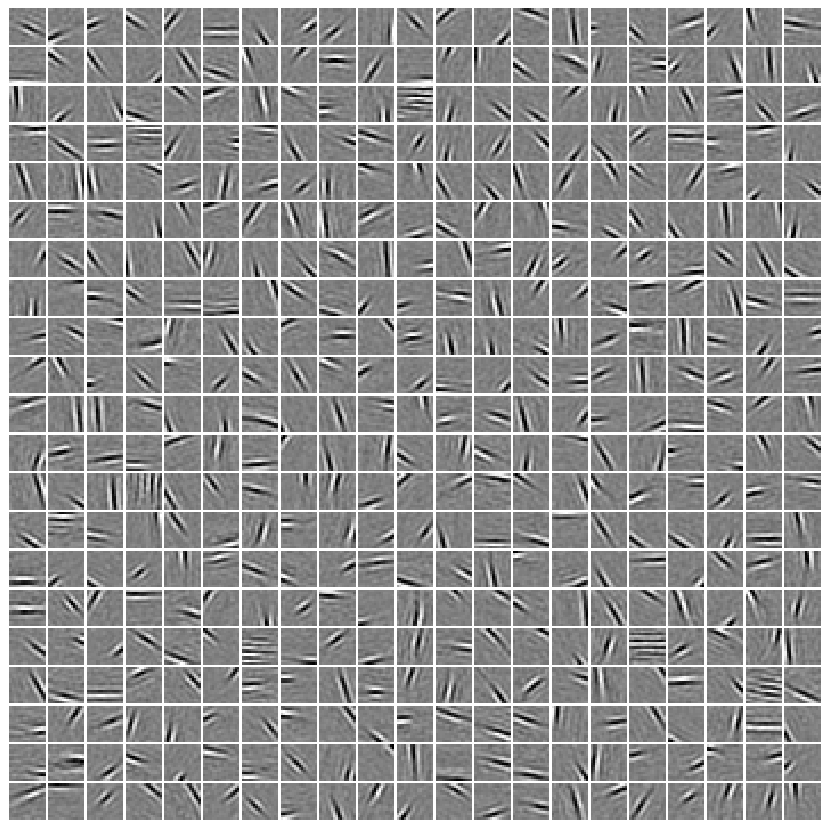

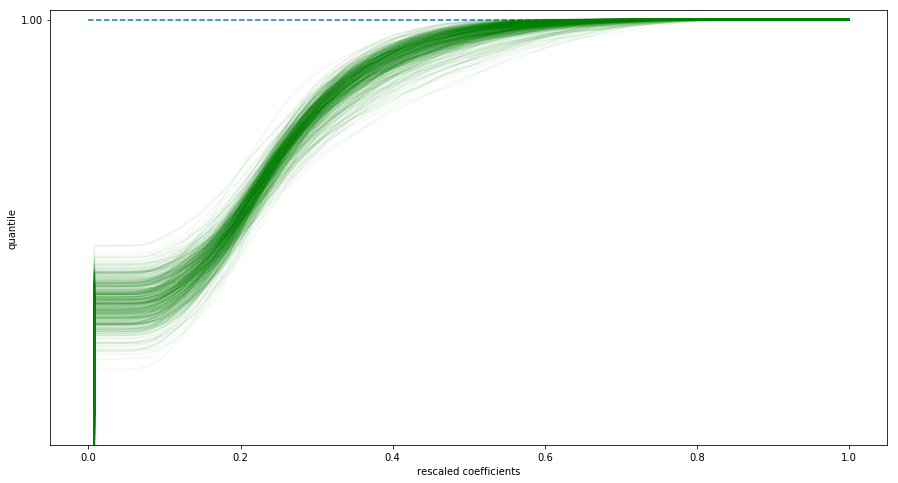

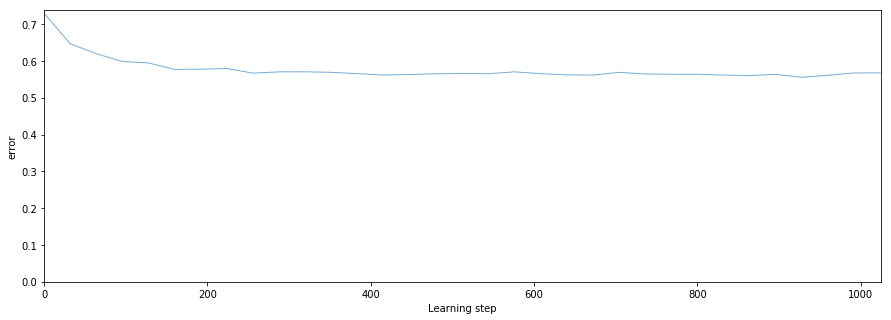

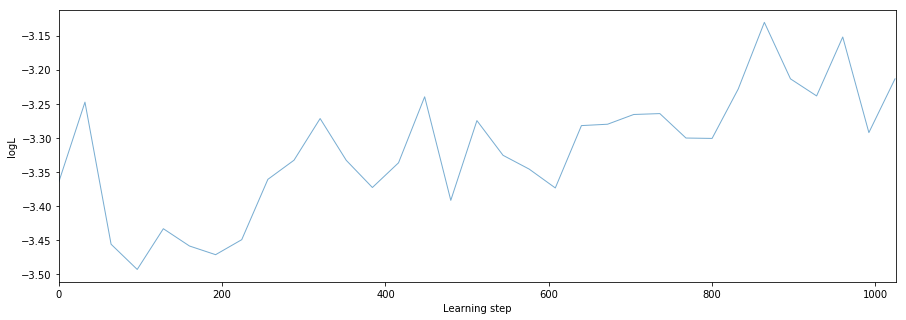

In [9]:
list_figures = ['show_dico', 'time_plot_error', 'time_plot_logL', 'show_Pcum']#, 'plot_variance',  'plot_variance_histogram',  'time_plot_prob',  'time_plot_kurt',  'time_plot_var']
dico = shl.learn_dico(data=data, list_figures=list_figures, matname=matname)

In [10]:
help(dico)

Help on SparseHebbianLearning in module shl_scripts.shl_learn object:

class SparseHebbianLearning(builtins.object)
 |  Sparse Hebbian learning
 |  
 |  Finds a dictionary (a set of atoms) that can best be used to represent data
 |  using a sparse code.
 |  
 |  Parameters
 |  ----------
 |  
 |  n_dictionary : int,
 |      Number of dictionary elements to extract
 |  
 |  eta : float or dict
 |      Gives the learning parameter for the homeostatic gain.
 |  
 |  n_iter : int,
 |      total number of iterations to perform
 |  
 |  eta_homeo : float
 |      Gives the learning parameter for the homeostatic gain.
 |  
 |  alpha_homeo : float
 |      Gives the smoothing exponent  for the homeostatic gain
 |      If equal to 1 the homeostatic learning rule learns a linear relation to
 |      variance.
 |  
 |  dictionary : array of shape (n_dictionary, n_pixels),
 |      initial value of the dictionary for warm restart scenarios
 |      Use ``None`` for a new learning.
 |  
 |  fit_algorith

In [11]:
print('size of dictionary = (number of filters, size of imagelets) = ', dico.dictionary.shape)
print('average of filters = ',  dico.dictionary.mean(axis=1).mean(), 
      '+/-',  dico.dictionary.mean(axis=1).std())
SE = np.sqrt(np.sum(dico.dictionary**2, axis=1))
print('average energy of filters = ', SE.mean(), '+/-', SE.std())

size of dictionary = (number of filters, size of imagelets) =  (441, 256)
average of filters =  2.139618290660281e-08 +/- 0.0017210889302107853
average energy of filters =  1.0 +/- 4.669154410371712e-17


## coding

The learning itself is done via a gradient descent but is highly dependent on the coding / decoding algorithm. This belongs to a another function (in the [shl_encode.py](https://github.com/bicv/SparseHebbianLearning/blob/master/shl_scripts/shl_encode.py) script)

In [12]:
sparse_code = shl.code(data, dico, matname=matname, l0_sparseness=45)
print('number of codes, size of codewords = ', sparse_code.shape)
print('average of codewords = ', sparse_code.mean())
print('average energy of codewords = ', sparse_code.std(axis=0).mean())
print('std of the average of individual patches = ', sparse_code.mean(axis=0).std())

loading the code called : cache_dir/basics_coding.npy
number of codes, size of codewords =  (65520, 441)
average of codewords =  0.06318881605789944
average energy of codewords =  0.22797624876374106
std of the average of individual patches =  0.022392540448781074


In [13]:
patches = sparse_code @ dico.dictionary
print('number of codes, size of reconstructed images = ', patches.shape)

number of codes, size of reconstructed images =  (65520, 256)


In [14]:
error = data - patches
print('average of residual patches = ', error.mean(), '+/-', error.mean(axis=1).std())
SE = np.sqrt(np.sum(error**2, axis=1))
print('average energy of residual = ', SE.mean(), '+/-', SE.std())

average of residual patches =  0.0006091514540213569 +/- 0.013866774475701123
average energy of residual =  6.7384288749233825 +/- 2.093675496729803


## Version used

In [15]:
%load_ext version_information
%version_information numpy, shl_scripts

Software versions
Python 3.6.5 64bit [GCC 4.2.1 Compatible Apple LLVM 9.1.0 (clang-902.0.39.2)]
IPython 6.5.0
OS Darwin 17.7.0 x86_64 i386 64bit
numpy 1.15.1
shl_scripts 20171221
Thu Sep 27 00:30:53 2018 CEST